# Time Series

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess

%matplotlib inline
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair
import warnings
warnings.filterwarnings('ignore')

## Morning Lecture: Fundamental Concepts

A **time series** is a specific type of data, where measurements of a single quantity are taken over time.

When speaking in equations, we will generally represent time with an index $i$, and the observations from the time series as $y_i$.  So the time series as a whole is:

$$y_1, y_2, y_3, \ldots$$

### Examples

A good source for time series data is [Google Searchs](https://www.google.com/trends/) where you can find how the popularity of a search term varies over time:

We've provided some chosen Google Searchs in the `data` directory.

Let's plot these trends and look for some interesting patterns:

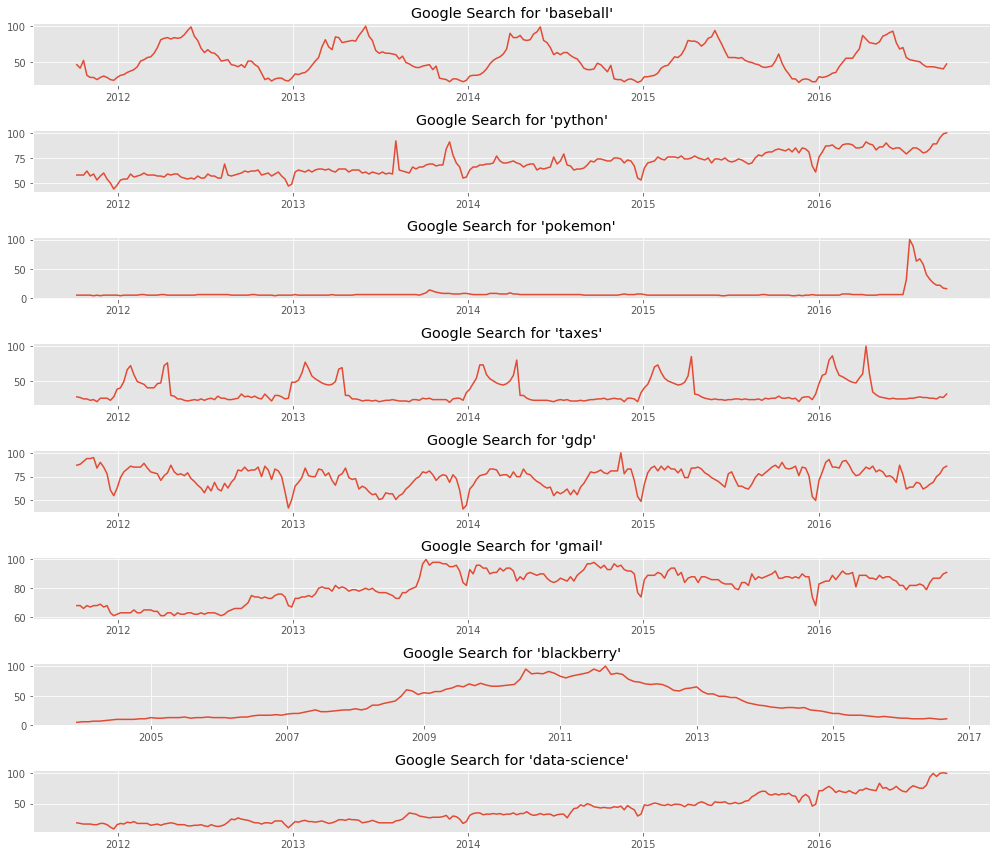

In [2]:
def read_google_search_data(term):
    filename = os.path.join('.', 'data', ''.join(['google-search-', term, '.csv']))
    df = pd.read_csv(filename, parse_dates=['week'], index_col='week')
    return df.iloc[:, 0]

google_search_terms = ['baseball', 'python', 'pokemon', 'taxes',
    'gdp', 'gmail', 'blackberry', 'data-science']

google_searches = { term: read_google_search_data(term) for term in google_search_terms }

def plot_google_search_data(ax, term):
    time_series = google_searches[term]
    ax.plot(time_series.index, time_series)
    ax.set_title("Google Search for '{}'".format(term))

_, axs = plt.subplots(len(google_searches), figsize=(14, 12))

for ax, term in zip(axs, google_search_terms):
    plot_google_search_data(ax, term)

plt.tight_layout()

Some observations:

- Searches for **baseball** show very strong oscillations aligned with the baseball season.  Search volume increases quickly as the season begins, and then falls off as the season goes on
- Searches for **python** show a general increase over time, probably influenced by the popularity of the language itself.  There may be evidence that searches decrease as specific periods of the year, most noticeably the end of year, when people are not working
- Searches for **pokemon** spike suddenly at a recent date, pointing to a one-time event greatly increasing interest
- Searches for **taxes** spike regularly at two specific points of the year, with the interest being heightened between those two dates.  At other times of the year, searches revert to a low rate
- Searches for **gdp** show a more random pattern than the others.  There is some evidence for *stickiness* in the trend, low values beget low subsequent values, and high values beget high subsequent values
- Searches for **gmail** show a pattern reminiscent of python, but there are sudden shifts where the baseline level jumps to a new value
- Searches for **blackberry** have a non-linear trend over time, they increase to a peak popularity, then decrease to almost nothing

**Activity:** What patterns do you see for **data-science**?

## Basic Concepts

Various different time series often show common patterns.  Attaching words to these patterns allows us to build a common language to discuss time series.

### Trends

A **trend** in a time series is a gradual change in average level as time moves on.  A trend an be *increasing*, *decreasing*, or *neither* (if, for example, a trend changes direction at some point in time).

Searches for **python** show a steady increasing trend:

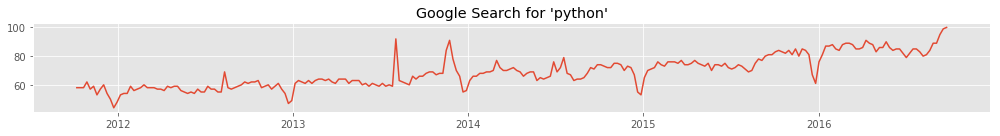

In [3]:
_, ax = plt.subplots(1, figsize=(14, 2))

plot_google_search_data(ax, 'python')

plt.tight_layout()

Searches for **blackberry** show a non-linear trend:

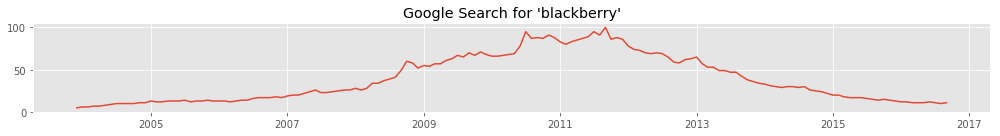

In [4]:
_, ax = plt.subplots(1, figsize=(14, 2))

plot_google_search_data(ax, 'blackberry')

plt.tight_layout()

**Question:** How you you describe the trend in `data-science`?

You can often use a regression model to capture a general trend in the time series.

Let's try to capture the linear trend in the python search data by fitting a simple linear model and using its predictions on the training data:

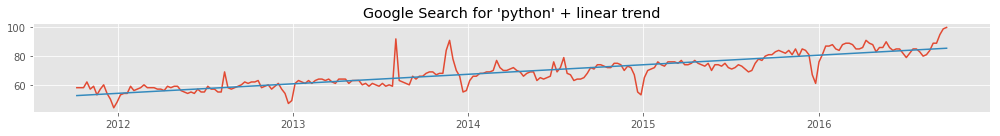

In [5]:
def fit_linear_trend(time_series):
    X = np.arange(len(time_series))
    X = sm.add_constant(X, prepend=False)

    y = time_series.values

    return sm.OLS(y, X).fit().predict(X)

def plot_linear_trend(ax, term):
    plot_google_search_data(ax, term)

    time_series = google_searches[term]
    linear_trend = fit_linear_trend(time_series)
    ax.plot(time_series.index, linear_trend)
    ax.set_title("Google Search for '{}' + linear trend".format(term))

_, ax = plt.subplots(1, figsize=(14, 2))

plot_linear_trend(ax, 'python')

plt.tight_layout()

If we subtract out the fit trend from the original time series, we get the **detrended time series**:

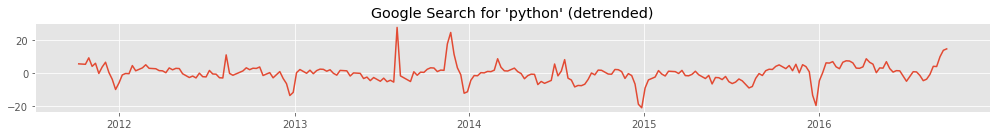

In [6]:
time_series = google_searches['python']
linear_trend = fit_linear_trend(time_series)
time_series_detrended = time_series - linear_trend

_, ax = plt.subplots(1, figsize=(14, 2))

ax.plot(time_series_detrended.index, time_series_detrended)
ax.set_title("Google Search for '{}' (detrended)".format(time_series.name))

plt.tight_layout()

Detrending a time series is often times a first step in analysing time series.

Many times, time series show a more sophisticated trend than a simple linear increase or decrease, in these cases a more sophisticated detrending procedure is needed.

In the following two cases, a linear detrending would be clearly inappropriate:

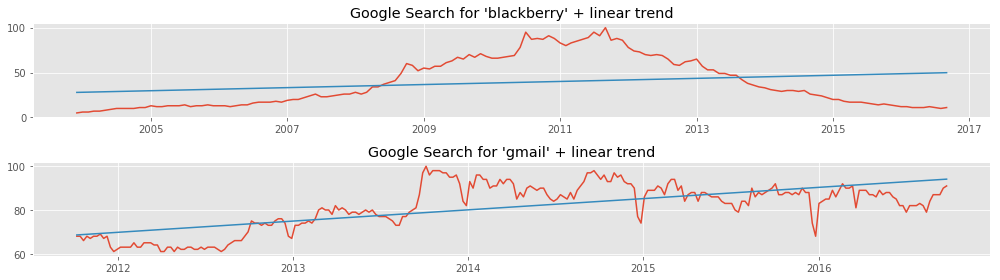

In [7]:
_, axs = plt.subplots(2, figsize=(14, 4))

plot_linear_trend(axs[0], 'blackberry')
plot_linear_trend(axs[1], 'gmail')

plt.tight_layout()

**Question:** Can you describe preciesely what is wrong with the linear model in both of these cases?

A very general approach that can be used for detrending data is to compute a **moving average**.

The moving average estimate of the trend at a data point $y_i$ is:

$$\hat{y}_i = \frac{1}{2w + 1} \sum_{j = -w}^{w} y_{i + j}$$

We esentially slide a **window** of a fixed side across our data, and average the values of the time series within the window.

The parameter $w$ controls how far to the left and to the right of $w$ we look when averaging the nearby points; this is called the **window**.

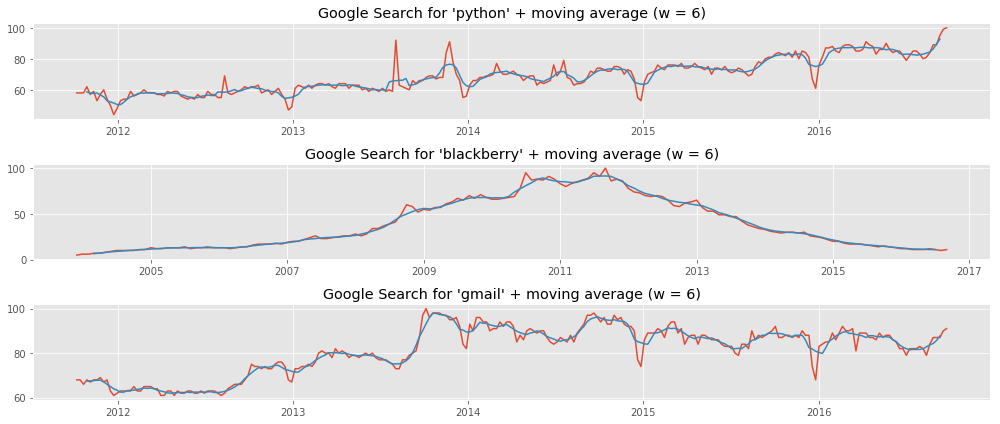

In [8]:
def fit_moving_average_trend(time_series, w):
    return pd.rolling_mean(time_series, w, center=True)

def plot_moving_average_trend(ax, name, w=6):
    plot_google_search_data(ax, name)

    time_series = google_searches[name]
    moving_average_trend = fit_moving_average_trend(time_series, w)
    ax.plot(time_series.index, moving_average_trend)

    ax.set_title("Google Search for '{}' + moving average (w = {})".format(name, w))

_, axs = plt.subplots(3, figsize=(14, 6))

plot_moving_average_trend(axs[0], 'python')
plot_moving_average_trend(axs[1], 'blackberry')
plot_moving_average_trend(axs[2], 'gmail')

plt.tight_layout()

Varying the window parameter changes the quality of the moving average fit:

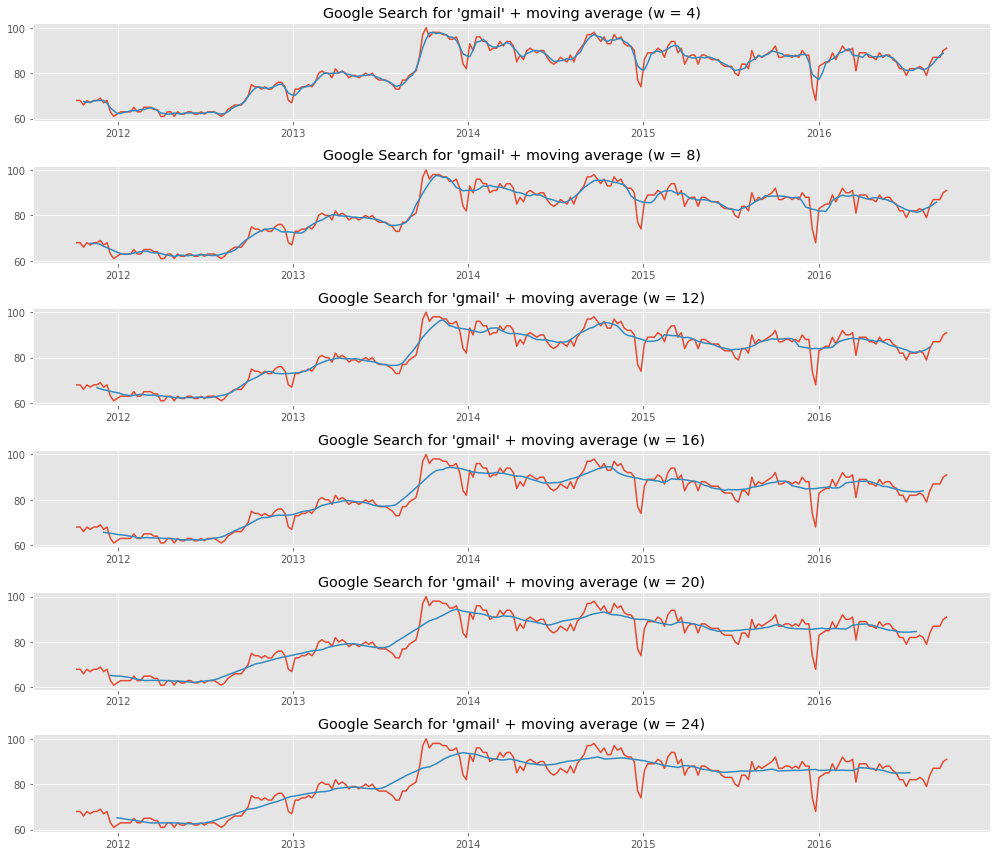

In [9]:
_, axs = plt.subplots(6, figsize=(14, 12))

for ax, w in zip(axs, [4, 8, 12, 16, 20, 24]):
    plot_moving_average_trend(ax, 'gmail', w)

plt.tight_layout()

We see that:
- Smaller values of $w$ tend to be influenced by noise of other non-trend patterns in the time series
- Large values of $w$ produce smoother estimates of the general trend in the data

For this reason, when estimating the trend component of a time series, we generally prefer larger windows.

Let's now fit a moving average smooth to the `data-science` time series for various windows, and plot the results:

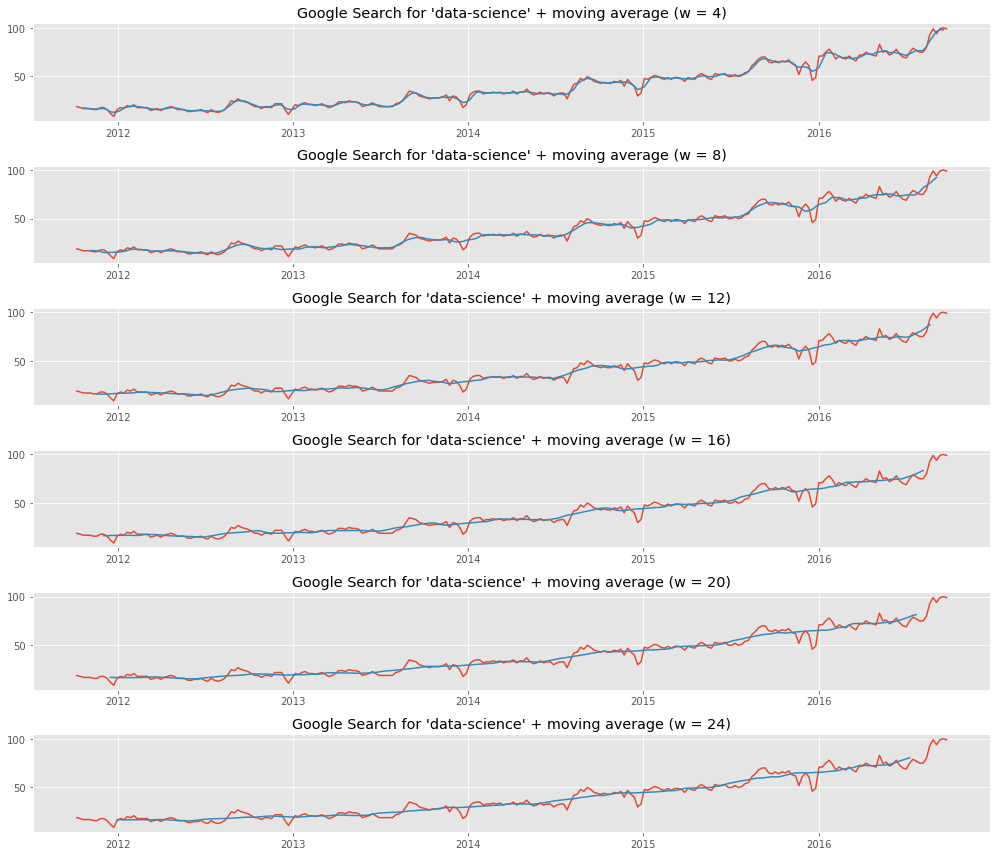

In [10]:
_, axs = plt.subplots(6, figsize=(14, 12))

for ax, w in zip(axs, [4, 8, 12, 16, 20, 24]):
    plot_moving_average_trend(ax, 'data-science', w)

plt.tight_layout()

When we have data that aligns with calendar regularities (quarterly, weekly, yearly), it is a good idea to chose the window so that an entire annual cycle is used in the smoothing.  This will average out any **seasonal** patterns in the data, as we will discuss below:

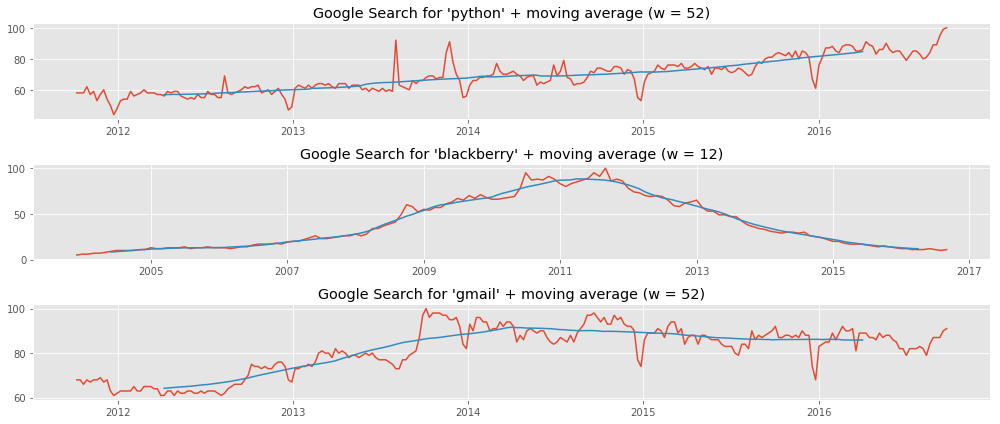

In [11]:
_, axs = plt.subplots(3, figsize=(14, 6))

for ax, term, w in zip(axs, ['python', 'blackberry', 'gmail'], [52, 12, 52]):
    plot_moving_average_trend(ax, term, w)

plt.tight_layout()

### Seasonality

A **seasonal** pattern in a time series is one that tends to appear regularly and that aligns with features of the calendar:

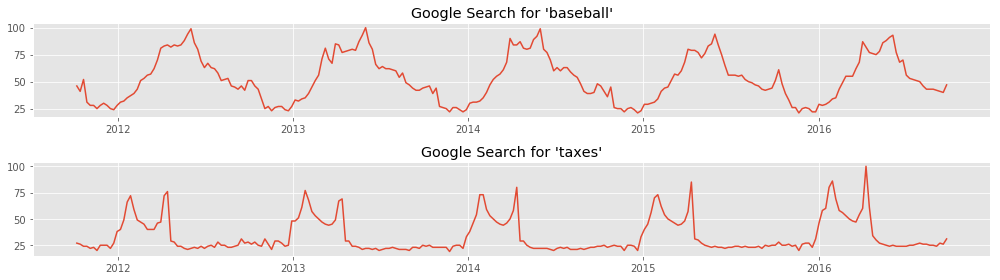

In [12]:
_, axs = plt.subplots(2, figsize=(14, 4))

plot_google_search_data(axs[0], 'baseball')
plot_google_search_data(axs[1], 'taxes')

plt.tight_layout()

Just like we can **detrend** a time series, we can also **deseasonalize** a time series.

The simplest method is to create dummy variables at regular intervals of the calendar:
- A dummy for every month
- Or, a dummy for every season
- Or, be even more granular than that

and then fit a linear regression to the time series using these dummy variables.

Here are linear regression model fits to the baseball and taxes trends with monthly and weekly dummy variables:

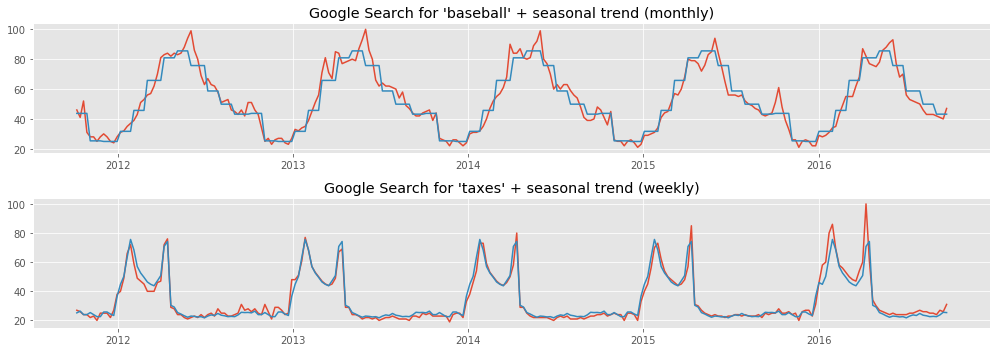

In [13]:
def fit_seasonal_trend(time_series, interval):
    intervals = getattr(time_series.index, interval)

    X = pd.get_dummies(intervals)

    # Take all but one dummies to avoid colinearity
    X = X.ix[:, 1:]

    X = sm.add_constant(X, prepend=False)
    y = time_series.values

    return sm.OLS(y, X).fit().predict(X)

def plot_seasonal_trend(ax, term, interval):
    plot_google_search_data(ax, term)

    time_series = google_searches[term]
    seasonal_trend = fit_seasonal_trend(time_series, interval)
    ax.plot(time_series.index, seasonal_trend)
    ax.set_title("Google Search for '{}' + seasonal trend ({}ly)".format(term, interval))

_, axs = plt.subplots(2, figsize=(14, 5))

plot_seasonal_trend(axs[0], 'baseball', 'month')
plot_seasonal_trend(axs[1], 'taxes', 'week')

plt.tight_layout()

To deseasonalize, we simply subtract out the seasonal predictions:

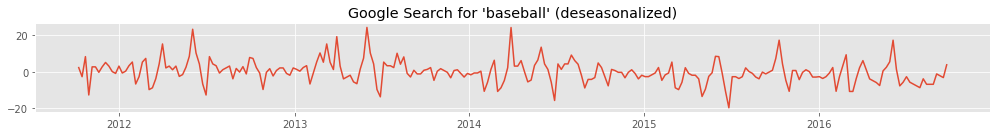

In [14]:
time_series = google_searches['baseball']
seasonal_trend = fit_seasonal_trend(time_series, 'month')
seasonal_trend = pd.Series(seasonal_trend.values, index=time_series.index)
time_series_deseasonalized = time_series - seasonal_trend

_, ax = plt.subplots(1, figsize=(14, 2))

ax.plot(time_series_detrended.index, time_series_deseasonalized)
ax.set_title("Google Search for '{}' (deseasonalized)".format(time_series.name))

plt.tight_layout()

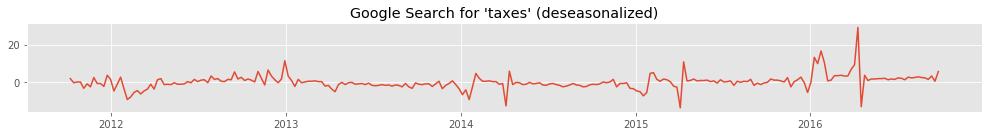

In [15]:
time_series = google_searches['taxes']
seasonal_trend = fit_seasonal_trend(time_series, 'week')
seasonal_trend = pd.Series(seasonal_trend.values, index=time_series.index)
time_series_deseasonalized = time_series - seasonal_trend

_, ax = plt.subplots(1, figsize=(14, 2))

ax.plot(time_series_detrended.index, time_series_deseasonalized)
ax.set_title("Google Search for '{}' (deseasonalized)".format(time_series.name))

plt.tight_layout()

## Trend-Seasonal-Residual Decomposition

The **Classical Trend-Seasonal-Residual Decomposition** expresses a time series as the sum of three components:

$$y_t = T_t + S_t + R_t$$

and is accomplished as follows:

Suppose, for definiteness, that we are working with *weekly* data, so that each $52$ observations forms a calendar year.  Then, the time series is decomposed as follows:

1. Compute the trend component $T_t$ using a moving average with window width $52$ (or $12$ for monthly data.  Then detrend the time series
2. Compute the seasonal component $S_t$ of the detrended time series $y_t - T_t$ by averaging together the observations that fall in the same week (or month, if monthly data).  **Note**, this is *equivalent* to fitting a linear regression to the detrended data with an indicator for each week, and then making predictions for each week of the original time series
3. The **remainder**, or **error**, or **residual** time series $E_t$ is $y_t - T_t - S_t$

Statsmodels implements the classical decomposition as `seasonal_decompose`.

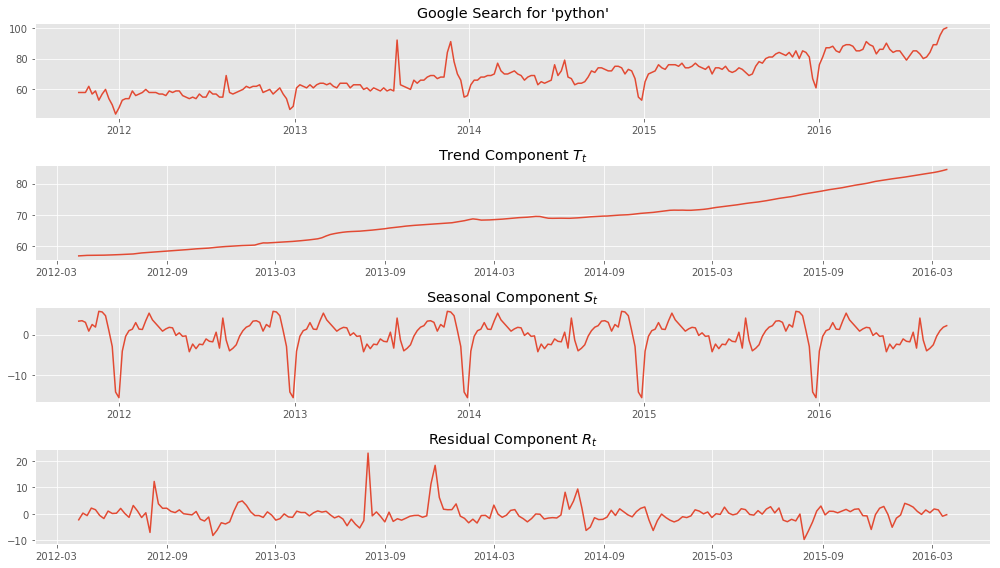

In [16]:
def fit_seasonal_decomposition(time_series):
    return sm.tsa.seasonal_decompose(time_series)

def plot_seasonal_decomposition(axs, term):
    time_series = google_searches[term]
    seasonal_decomposition = fit_seasonal_decomposition(time_series)

    axs[0].plot(time_series.index, time_series)
    axs[0].set_title("Google Search for '{}'".format(term))

    axs[1].plot(time_series.index, seasonal_decomposition.trend)
    axs[1].set_title('Trend Component $T_t$')

    axs[2].plot(time_series.index, seasonal_decomposition.seasonal)
    axs[2].set_title('Seasonal Component $S_t$')

    axs[3].plot(time_series.index, seasonal_decomposition.resid)
    axs[3].set_title('Residual Component $R_t$')

_, axs = plt.subplots(4, figsize=(14, 8))

plot_seasonal_decomposition(axs, 'python')

plt.tight_layout()

This decomposition validates our description of the time series earlier as a general upwards trend, but with some seasonal behavior (like a sharp drop off in queries around winter time).

When the decomposition is working well, the residual component $R_t$ should show no seasonal or trend patterns.

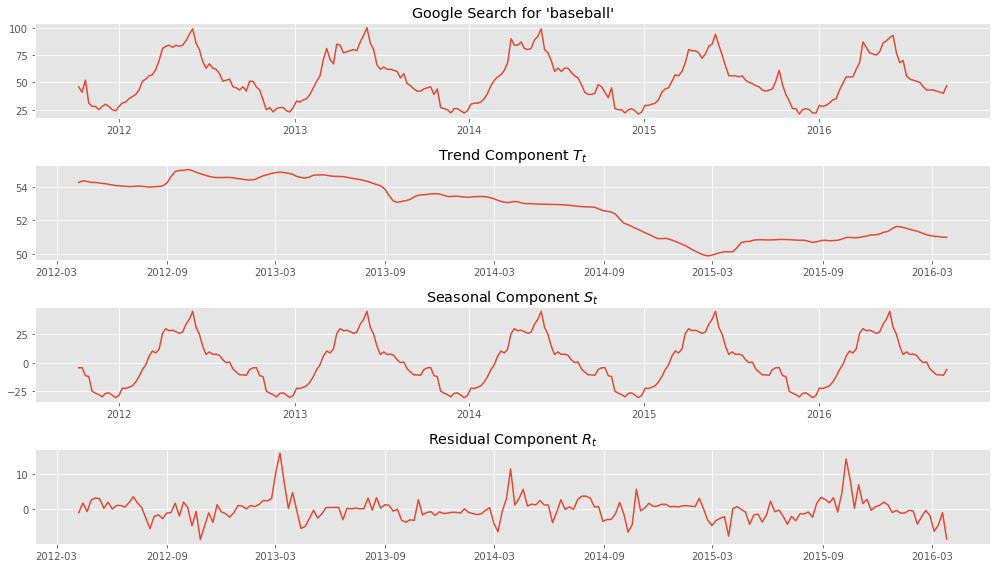

In [17]:
_, axs = plt.subplots(4, figsize=(14, 8))

plot_seasonal_decomposition(axs, 'baseball')

plt.tight_layout()

**Note:** The different components of the time series are often shown on very different scales, so make sure to pay close attention to the $y$-axis labels.

Sometimes the classical decomposition is not powerful enough to capture the trend or seasonal components of a time series.

The `gmail` time series decomposition shows some interesting behavior in the residuals:

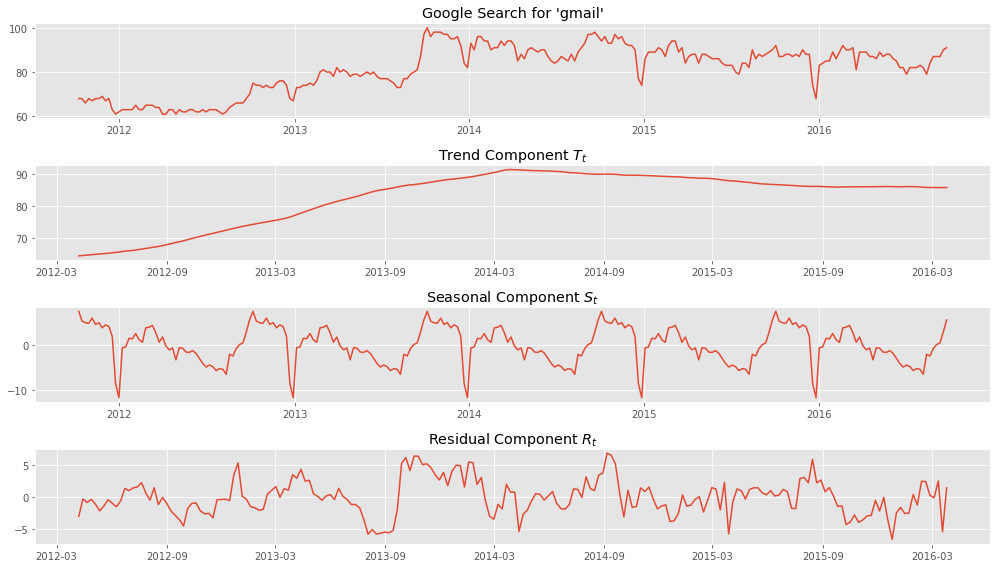

In [18]:
_, axs = plt.subplots(4, figsize=(14, 8))

plot_seasonal_decomposition(axs, 'gmail')

plt.tight_layout()

Around October 2013 the time series showed a clear and sudden change in average level, which the trend component could not adapt to quickly enough.  Consequently, this discontinuity appears in the residual series.

A more sophisticated procedure should be used to decompose this time series, which allows for a discontinuity in the observed time series, or fits a more sophisticated model for the trend component.

Let's decompose the `data-science` time series.  What patterns do you see?  Is the decomposition appropriate?

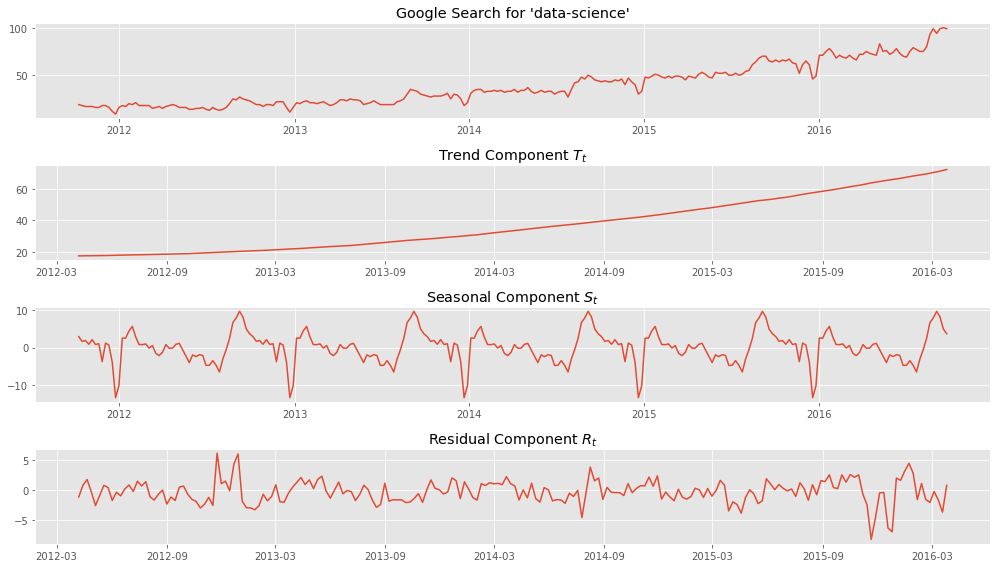

In [19]:
_, axs = plt.subplots(4, figsize=(14, 8))

plot_seasonal_decomposition(axs, 'data-science')

plt.tight_layout()

## Statistical Concepts

In the afternoon we will present some statistical models for time series.  For now, we will present some fundamental concepts.

### Random Processes

Up to now we have only considered a single manifestation of a single time series $y_1, y_2, y_3, \ldots$

Let's now impose a probability model on this data, i.e., now we consider time series as **random objects that can be sampled**.

Formally, we consider a single time series as a *sample* from a sequence of random variables:

$$Y_1, Y_2, Y_3, \ldots$$

Note that we are **not** assuming that these random variables are independent, **it is very likely that in a time series that sample we draw at time $t$ influences the sample we draw at time $t+1$**.

When we need to distinguish the data from the statistical model that we are assuming generated the data, we call:
- The data a **time series**
- The data generating process a **random process**, or more specifically, a **time series random process**

### White Noise

The simplest possible random process from this perspective occurs when each $Y_i$ is independent from all the rest, and all the $Y$'s are identically distributed.

In this case the time series is called **white noise**.

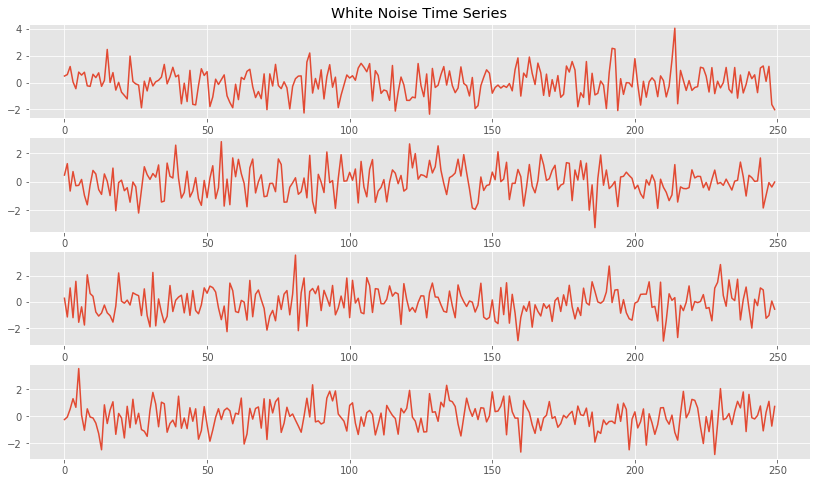

In [20]:
def white_noise(size=250):
    return pd.Series(np.random.normal(size=size))

_, axs = plt.subplots(4, figsize=(14, 8))

for ax in axs:
    time_series = white_noise()
    ax.plot(time_series.index, time_series)

axs[0].set_title('White Noise Time Series')

White noise shows no trend, no seasonal patterns, no cyclic behavior, and no stickiness.

### Stationarity

White noise has the simplest possible structure: everything is independent.

As mentioned, in most time series observations will **not be independent**.  Nonetheless, there is a useful concept that characterizes the type of dependence found in many time series.

A time series random process $Y_1, Y_2, Y_3, \ldots$ is said to be **strictly stationary** if the distribution of all equally spaced tuples taken from the time series are identical.  That is, if

$$(Y_{i_1}, Y_{i_2}, \ldots, Y_{i_k})$$

and

$$(Y_{i_1 + h}, Y_{i_2 + h}, \ldots, Y_{i_k + h})$$

are always identically distributed.

This means that the properties (e.g., mean, variance, ...) of the time series **do not depend on when you begin observing it**.

In other words, if you start observing the time series, watch for an hour, go cook a meal for an hour, then watch the time series for another hour, **it does not matter if the meal you cooked was breakfast, lunch, or dinner** the properties of the time series you observe will be the same in any case.

**Discussion:** Can stationary time series show trends?  Can stationary time series show seasonality?  Can stationary time series be sticky?

**Discussion:** Can the variance of a stationary time series change over time?

**Discussion:** Is the following time series stationary?  No?  Summarize all the reasons why not.

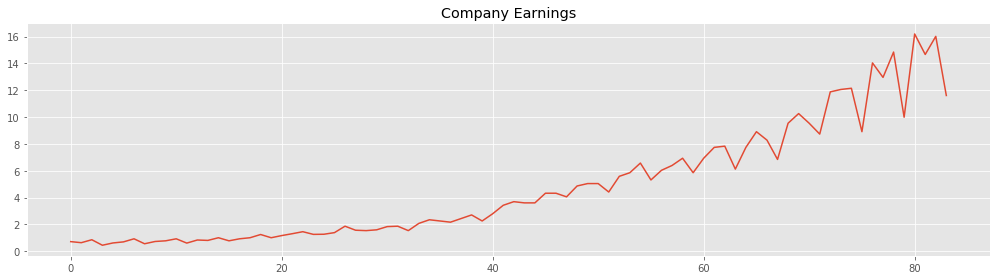

In [21]:
df = pd.read_csv(os.path.join('.', 'data', 'earnings.csv'))
earnings = df.earnings

_, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(earnings.index, earnings)
ax.set_title('Company Earnings')

plt.tight_layout()

**Questions:**
- How would you transform this time series to be stationary?
- How would you remove the trend?
- How would you stabilize the variance?  [This may help](http://stats.stackexchange.com/questions/18930/transformation-for-stabilizing-variance-in-time-series).

### Differencing

Most time series encountered in nature are **not** stationary, but there is often a simple way to transform one to be stationary.

Given a time series $y_1, y_2, y_3, \ldots$, the **first difference series** is:

$$y_2 - y_1, y_3 - y_2, y_4 - y_3, \ldots$$

The aim of differencing a time series is to remove the trend component, which stationary time series cannot have.

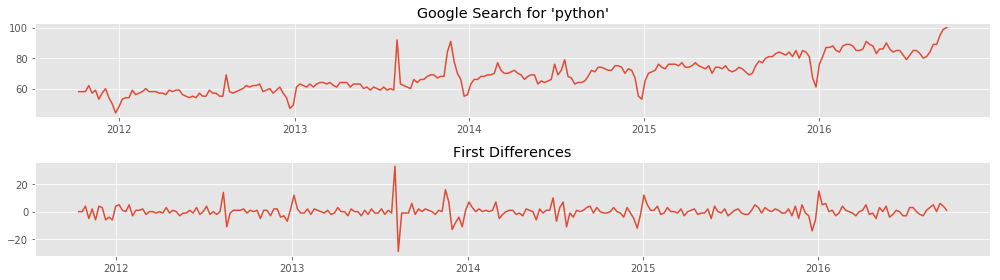

In [22]:
def plot_time_series_and_first_difference(axs, term, time_series=None):
    if time_series is None:
        time_series = google_searches[term]
        title = "Google Search for '{}'".format(term)
    else:
        title = term
    axs[0].plot(time_series.index, time_series)
    axs[0].set_title(title)
    axs[1].plot(time_series.index, time_series.diff())
    axs[1].set_title('First Differences')

_, axs = plt.subplots(2, figsize=(14, 4))

plot_time_series_and_first_difference(axs, 'python')

plt.tight_layout()

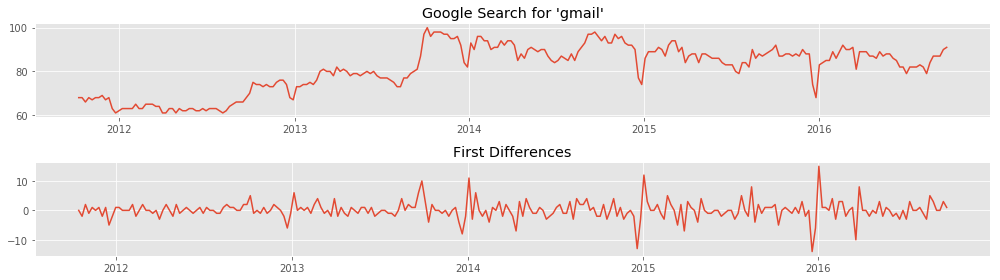

In [23]:
_, axs = plt.subplots(2, figsize=(14, 4))

plot_time_series_and_first_difference(axs, 'gmail')

plt.tight_layout()

**Discussion:** Do these different time series look stationary?

Let's compute and plot the first difference time series for `data-science`.  Does it look stationary?

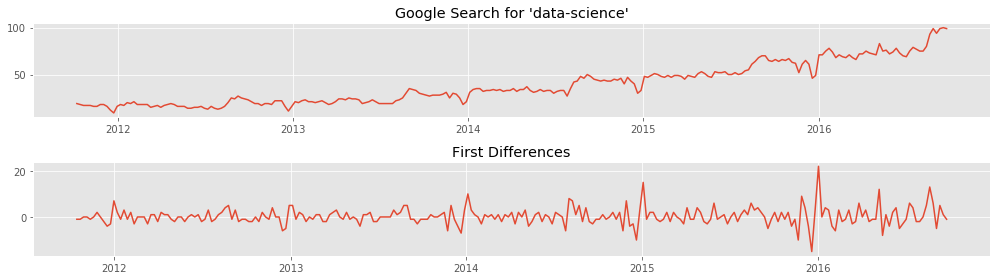

In [24]:
_, axs = plt.subplots(2, figsize=(14, 4))

plot_time_series_and_first_difference(axs, 'data-science')

plt.tight_layout()

**Question:** If you are given the *differences* of a time series, how can you recover the original time series?

### Example: Random Walks

When a differenced time series is *white noise* (**note**: *not all stationary time series are white noise*, as we will demonstrate below), we have the following relationship:

$$y_{i+1} - y_i = e_i$$

or

$$y_{i+1} = y_i + e_i$$

This type of series is called a **random walk** and is a very common statistical model for time series.

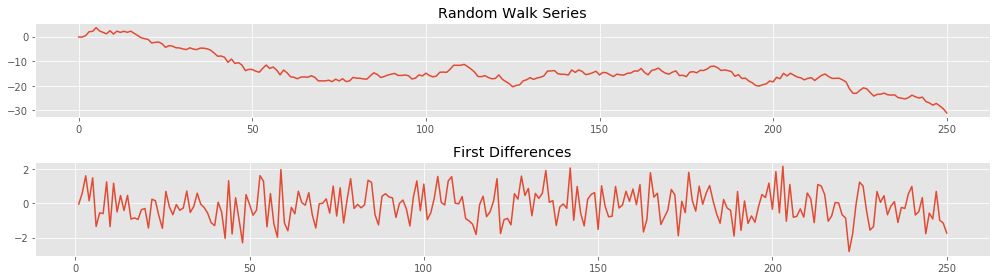

In [25]:
def random_walk(size):
    noise = white_noise(size + 1)
    walk = np.cumsum(noise)
    return walk

def plot_random_walk(axs, size=250):
    walk = random_walk(size)
    axs[0].plot(walk.index, walk)
    axs[0].set_title('Random Walk Series')
    axs[1].plot(walk.index, walk.diff())
    axs[1].set_title('First Differences')

_, axs = plt.subplots(2, figsize=(14, 4))

plot_random_walk(axs)

plt.tight_layout()

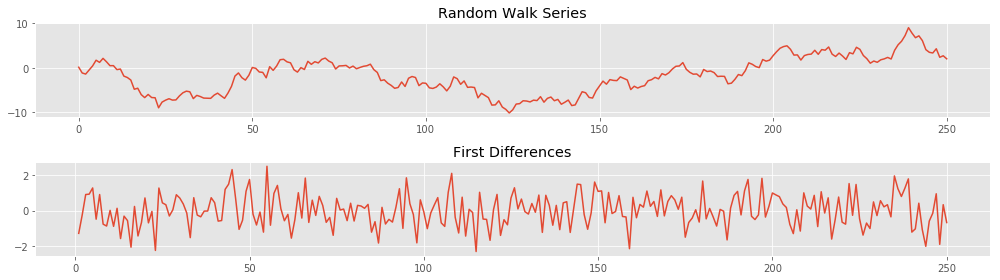

In [26]:
_, axs = plt.subplots(2, figsize=(14, 4))

plot_random_walk(axs)

plt.tight_layout()

Notice that random walks, although constructed from totally random components, can show very strong evidence of *trends*.  This is because random walks are sticky, once they randomly elevate to an extreme value, subsequent values of the time series are only small adjustments to previous values, so the value of the time series tends to stay elevated.

### Linear Combinations of White Noise

A simple way to construct a diverse set of stationary time series is as **linear combinations of white noise**.

Suppose that:

$$e_1, e_2, e_3, \ldots$$

is a white noise process.  Then any time series $s$ created by linearly combining lagged values of $e$ is stationary:

$$s_i = \mu + e_i + a_1 e_{i-1} + a_2 e_{i-2} + \cdots + a_k e_{i-k}$$

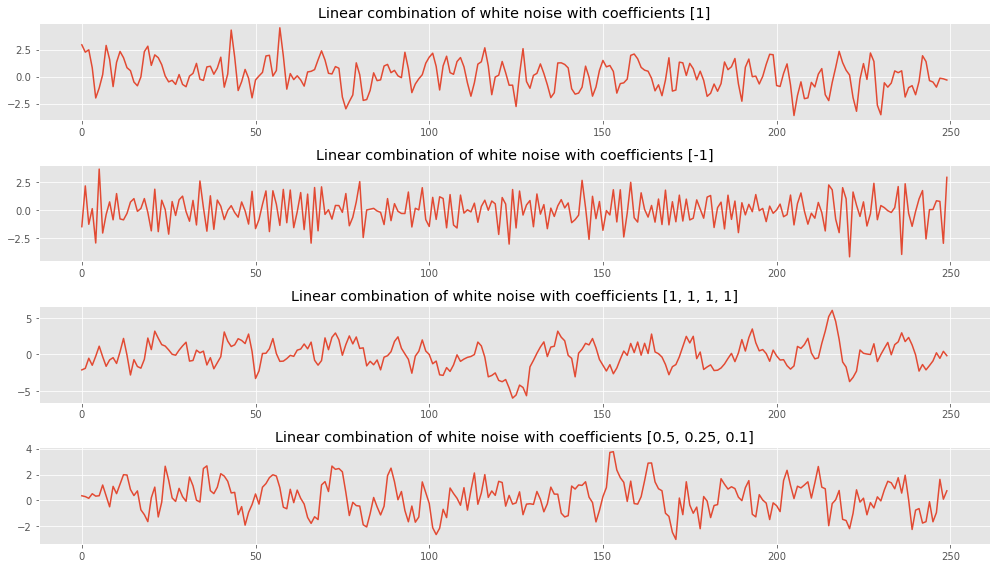

In [27]:
def linear_combination_of_white_noise(size, coefs):
    coefs = np.asarray(coefs)
    n_coefs = len(coefs)
    noise_size = size + n_coefs
    noise = np.random.normal(size=noise_size)

    # np.convolve reverses the second array; we need to subset the result to remove edge effects
    time_series = np.convolve(noise, coefs[::-1])[(n_coefs-1):(noise_size-1)]

    return pd.Series(time_series)

def plot_linear_combination_of_white_noise(size, coefs, ax):
    time_series = linear_combination_of_white_noise(size, coefs)
    ax.plot(time_series.index, time_series)
    ax.set_title('Linear combination of white noise with coefficients {}'.format(
            str(list(coefs[1:]))))

_, axs = plt.subplots(4, figsize=(14, 8))

plot_linear_combination_of_white_noise(250, [1, 1], ax=axs[0])
plot_linear_combination_of_white_noise(250, [1, -1], ax=axs[1])
plot_linear_combination_of_white_noise(250, [1, 1, 1, 1, 1], ax=axs[2])
plot_linear_combination_of_white_noise(250, [1, 0.5, 0.25, 0.1], ax=axs[3])

plt.tight_layout()

**All the time series above are sampled from a stationary process.**

A linear combination of white noise is traditionally called a **MA time series**.

- MA(1) contains one lagged term: $s_i = \mu + e_i + a_1 e_{i-1}$
- MA(2) contains two lagged terms: $s_i = \mu + e_i + a_1 e_{i-1} + a_2 e_{i-2}$
- And so on...

**Note:** MA stands for *moving average*, even though this has *nothing to do with* a moving average as we discussed earlier.  Unfortunately, the name has stuck, and you'll have to get use to it.  My recommendation is to call them "em ay" time series, and reserve the full words for true moving averages.

**Activity:** Take a few minuets to play around with generating some MA time series.  Can you create any interesting behavior out of pure randomness?

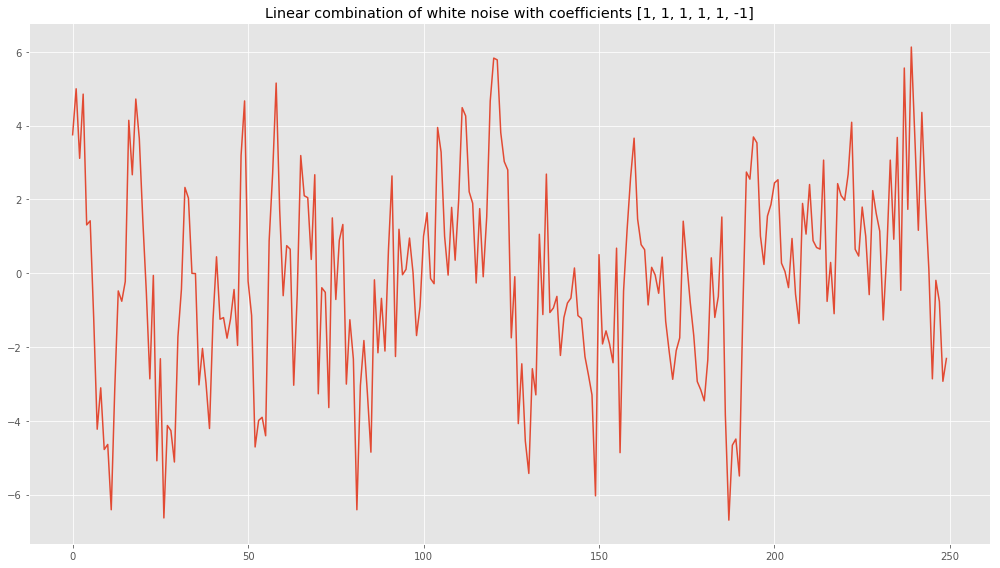

In [28]:
_, ax = plt.subplots(1, figsize=(14, 8))

plot_linear_combination_of_white_noise(250, [1, 1, 1, 1, 1, 1, -1], ax=ax)

plt.tight_layout()

### Tests for Stationarity

Stationarity can be hard to visualize, so there are some statistical hypothesis tests that you can use to indicate stationarity.

The **Augmented Dickey-Fuller test** (ADF) is setup as follows:

- $H_0$: The time series is **not-stationary**
- $H_{\text{a}}$: The time series is stationary

It is available in Statsmodels as `tsa.stattools.adfuller`.

White noise time series are stationary:

In [29]:
for _ in range(5):
    time_series = white_noise(size=250)
    test = sm.tsa.stattools.adfuller(time_series)
    print 'ADF p-value: {:2.2f}'.format(test[1])

ADF p-value: 0.00
ADF p-value: 0.00
ADF p-value: 0.00
ADF p-value: 0.00
ADF p-value: 0.00


MA time series are stationary:

In [30]:
for coefs in [[1, 1], [1, -1], [1, 1, 1, 1], [1, 0.5, 0.25, 0.1]]:
    time_series = linear_combination_of_white_noise(size=250, coefs=coefs)
    test = sm.tsa.stattools.adfuller(time_series)
    print 'ADF p-value: {:2.2f}'.format(test[1])

ADF p-value: 0.00
ADF p-value: 0.00
ADF p-value: 0.06
ADF p-value: 0.00


What about some of the time series we found in nature?

The `python` time series has an obvious trend, it is clearly not stationary and the test confirms it:

In [31]:
time_series = google_searches['python']
test = sm.tsa.stattools.adfuller(time_series)
print 'ADF p-value for `{}` time series: {:2.2f}'.format(time_series.name, test[1])

ADF p-value for `python` time series: 0.95


Maybe differencing helps?

In [32]:
time_series = time_series.diff()[1:]
test = sm.tsa.stattools.adfuller(time_series)
print 'ADF p-value for differenced `{}` time series: {:2.2f}'.format(time_series.name, test[1])

ADF p-value for differenced `python` time series: 0.00


**It sure did!**

The baseball time series is also stationary after differencing:

In [33]:
time_series = google_searches['baseball'].diff()[1:]
test = sm.tsa.stattools.adfuller(time_series)
print 'ADF p-value for `{}` time series: {:2.2f}'.format(time_series.name, test[1])

ADF p-value for `baseball` time series: 0.00


**Activity:** Test some of the other time series we've been experimenting with for stationality.  Does differencing improve the situation?

In [34]:
time_series = google_searches['gmail'].diff()[1:]
test = sm.tsa.stattools.adfuller(time_series)
print 'ADF p-value for `{}` time series: {:2.2f}'.format(time_series.name, test[1])

ADF p-value for `gmail` time series: 0.00


# Time Series - Models for Stationary Series - Afternoon Lecture

For the rest of the day, we will be working with *stationary* time series, and developing a statistical model for them.

## Autocorrelation

Recall the definition of strictly stationary:

A time series $Y_1, Y_2, Y_3, \ldots$ is said to be **strictly stationary** if the distribution of all equally spaced tuples taken from the time series are identical.  That is, if:

$$(Y_{i_1}, Y_{i_2}, \ldots, Y_{i_k}$$

and

$$(Y_{i_1 + k}, Y_{i_2 + k}, \ldots, Y_{i_3 + k})$$

are always identically distributed.

One consequence of this definition is that the correlation between two $Y$'s only depends on the lag between them:

$$Corr(Y_5, Y_2) = Corr(Y_4, Y_1) = Corr(Y_{144}, Y_{141}) = \cdots$$

These correlations between a time series and a lagged version of itself are called **autocorrelations**.

$$\gamma_k(Y)= Corr(Y_1, Y_{1+k}) = Corr(Y_2, Y_{2+k}) = Corr(Y_3, Y_{3+k}) = \cdots$$

Recall from earlier that the differenced baseball time series is **stationary** (according to the ADF test).

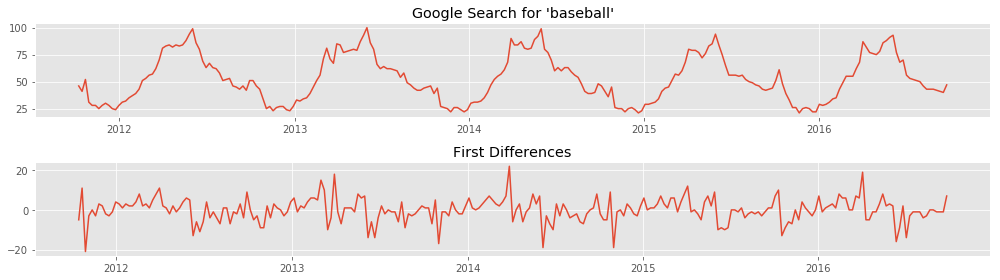

In [35]:
_, axs = plt.subplots(2, figsize=(14, 4))

plot_time_series_and_first_difference(axs, 'baseball')

plt.tight_layout()

We can draw some scatterplots to summarize the autocorrelation information in the baseball time series.

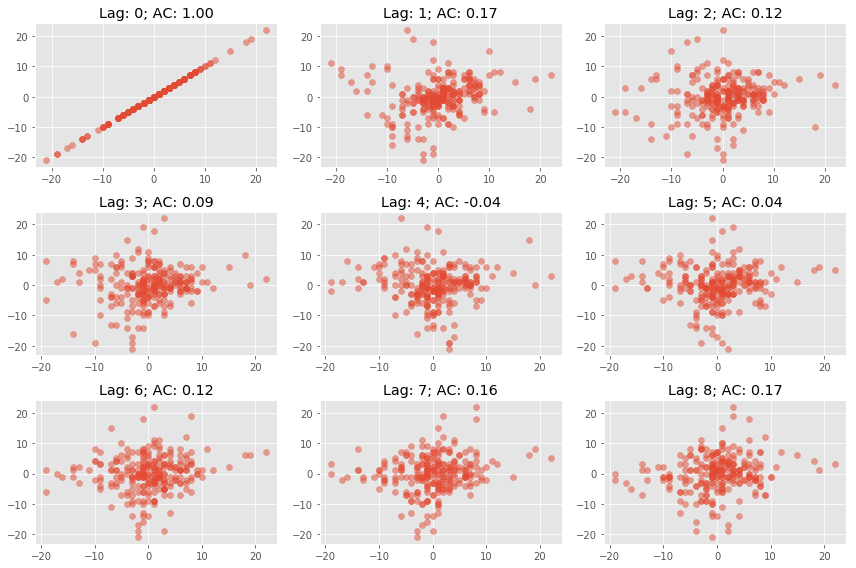

In [36]:
time_series = google_searches['baseball'].diff()[1:]

_, axs = plt.subplots(3, 3, figsize=(12, 8))

for lag, ax in enumerate(axs.flatten()):
    truncated = np.copy(time_series)[lag:]
    lagged = np.copy(time_series)[:len(truncated)]
    autocorrelation = np.corrcoef(truncated, lagged)[0, 1]
    ax.scatter(truncated, lagged, alpha=.5)
    ax.set_title('Lag: {}; AC: {:2.2f}'.format(lag, autocorrelation))

plt.tight_layout()

**Question:** Why does the first scatterplot here lie along a straight line?

A more immediate way to view the autocorrelation in a time series is with an **autocorrelation plot**:

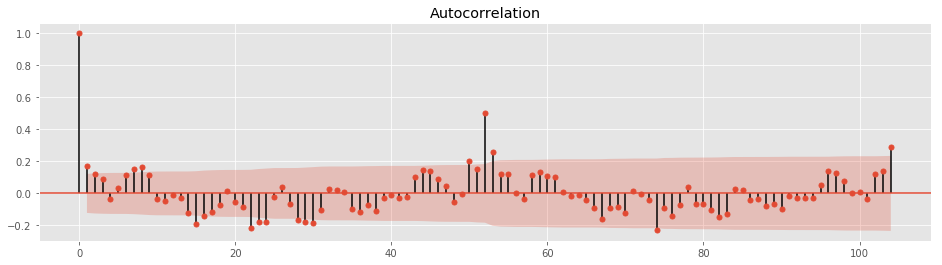

In [37]:
_, ax = plt.subplots(1, figsize=(16, 4))

sm.graphics.tsa.plot_acf(time_series, lags=2*52, ax=ax);

Each spike in this plot is an autocorrelation for a single lag.

The *first* spike is always at 1.0 (because any time series is perfectly correlated with itself).

The shaded region are 95% confidence bounds.  If *all* of the autocorrelations were truly zero, we would still expect to see about 5% of the spikes exceeding these bounds.

For the baseball example, we observe the following:
- There is a very striking spike at exactly 52 lags, which is the number of weeks in a year.  This is repeated, less significantly, at a lag of twice 52
- The first and 53'rd autocorrelations are positive and significant

**Discussion:** How do you interpret the large spike in autocorrelation at 52 weeks?

**Discussion:** Could the spike at 104 weeks be related to the spike at 52 weeks?

**Discussion:** Does the spike at 52 weeks *prevent the time series from being stationary*?

One potential issue with autocorrelations is the following:

If $y_i$ is correlated with $y_{i-1}$ **and** $y_{i-1}$ is correlated with $y_{i-2}$ then $y_{i-2}$ **necessarily** has some influence on $y_{i}$.

## Partial Autocorrelation

A **partial autocorrelation** plot controls for this effect:

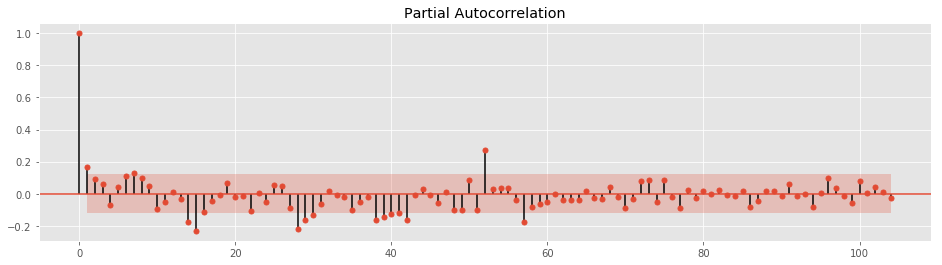

In [38]:
_, ax = plt.subplots(1, figsize=(16, 4))

sm.graphics.tsa.plot_pacf(time_series, lags=2*52, ax=ax);

Here, the spike at 52 weeks still appears, but the subsequent spike at 104 weeks has disappeared.  This demonstrates that the spike at 104 weeks was almost completely caused by the spike at 52 weeks.

**Discussion:** How do you think the partial autocorrelation plot is constructed.  **Hint**: It uses linear regression in a fundamental way.

**Discussion:** What would you expect from an autocorrelation plot of white noise?

### Autocorrelation of MA time series

Recall that MA time series are linear combinations of white noise with a possible constant term

$$s_i = \mu + e_i + a_1 e_{i-1} + \cdots + a_k e_{i-k}$$

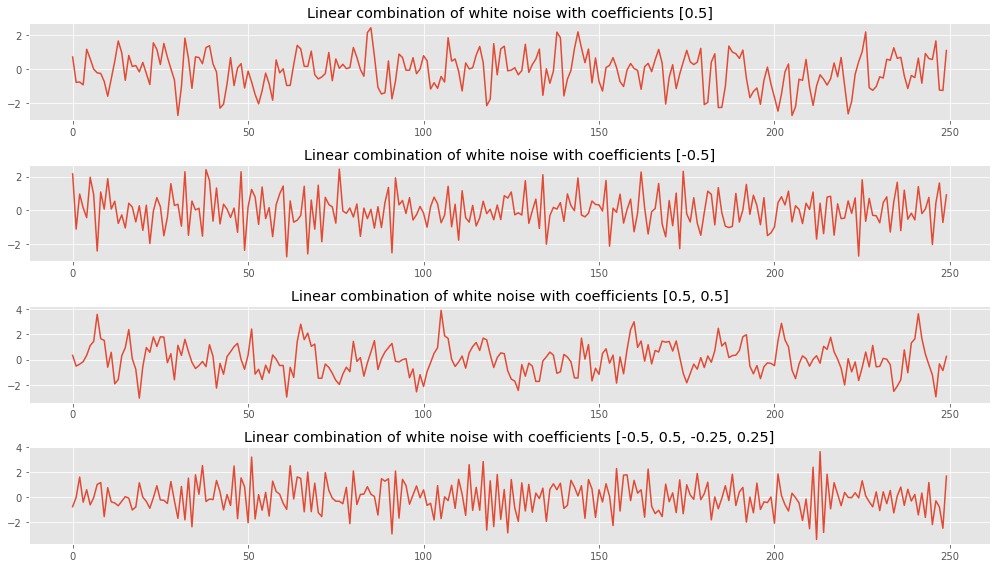

In [39]:
_, axs = plt.subplots(4, figsize=(14, 8))

ma_coefs = [[1, 0.5], [1, -0.5], [1, 0.5, 0.5], [1, -0.5, 0.5, -0.25, 0.25]]
for ax, coefs in zip(axs, ma_coefs):
    plot_linear_combination_of_white_noise(250, coefs, ax=ax)

plt.tight_layout()

**Discussion:** What will the autocorrelation of a MA time series look like?

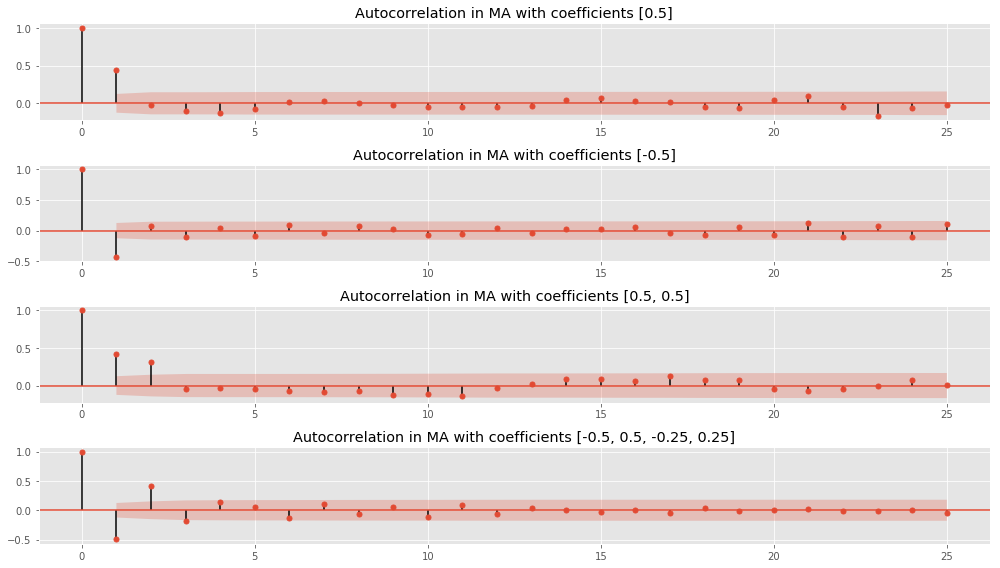

In [40]:
_, axs = plt.subplots(4, figsize=(14, 8))

for ax, coefs in zip(axs, ma_coefs):
    time_series = linear_combination_of_white_noise(size=250, coefs=coefs)
    sm.graphics.tsa.plot_acf(time_series, lags=25, ax=ax)
    ax.set_title('Autocorrelation in MA with coefficients {}'.format(str(list(coefs[1:]))))

plt.tight_layout()

For data generated from an MA model, the number of non-zero autocorrelations generally indicates the *order* of the model (the number of non-zero coefficients).

**Discussion:** Why?

### MA Models

Given stationary time series data, a reasonable question to ask is the following:

> Which MA time series would be most likely to generate this data?

This is the concept behind MA models.

A MA (moving average) model of order $k$ (also known as a $MA(k)$ model) attempts to represent a stationary time series as a linear combination of white noise:

$$s_i = \mu + e_i + a_1 e_{i-1} + \cdots + a_k e_{i-k}$$

**Discussion:** What technique do you think is used to determine the estimated coefficients when an MA model is fit?

Let's generate some MA data, fit MA models, and compare the coefficients.

In [41]:
def MA(time_series, order):
    # ARIMA is a more general model, which we are going to build up in pieces.
    return ARIMA(time_series, order=(0, 0, order)).fit()

def format_floats(L):
    return ['{:2.2f}'.format(f) for f in L]

for coefs in ma_coefs:
    order = len(coefs) - 1
    time_series = linear_combination_of_white_noise(size=250, coefs=coefs)
    model = MA(time_series.values, order)
    print "True      Coefficients: {: <20}\nEstimated Coefficients: {: <20}\n".format(
            str(format_floats(coefs[1:])),
            str(format_floats(model.params[1:])))

True      Coefficients: ['0.50']            
Estimated Coefficients: ['0.54']            

True      Coefficients: ['-0.50']           
Estimated Coefficients: ['-0.55']           

True      Coefficients: ['0.50', '0.50']    
Estimated Coefficients: ['0.48', '0.53']    

True      Coefficients: ['-0.50', '0.50', '-0.25', '0.25']
Estimated Coefficients: ['-0.52', '0.61', '-0.22', '0.17']



So it looks like the MA models recover the true coefficients from *actual* MA processes.  So far, so good.

Before we apply the MA model to real data, we need to introduce AR processes, and generalize everything to the ARIMA model.

### Intermission: Recursive Sequences

A **recursive sequence** (of numbers) is one where the subsequent values in the sequence are defined as functions of the preceding values.  For example:

- $y_i = 1$
- $y_i = y_{i-1} + 1; \ y_1 = 0$
- $y_i = - y_{i-1}; \ y_1 = 1$
- $y_i = 0.5 y_{i-1} + 0.25 y_{i-2}; \ y_1 = 1; y_2 = 1$

**Activity:** Sketch pictures of these recursive sequences.

**Bonus:**: Write a python function to draw a plot of a recursive sequence.  How should you specify the arguments to this function?  How can you factor the task into multiple functions so that each has a single responsibility?

### AR Processes

Another data generating process that (often, there are some restrictions on the coefficients) results in a stationary process is an **autoregressive** process.

In an autoregressive process, subsequent values of the time series are linear combinations of previous values of the time series plus some noise term (much like in regression we get a linear combination of predictors plus a noise term):

$$y_i = \mu + b_1 y_{i-1} + b_2 y_{i-2} + \cdots + b_k y_{i-k} + \epsilon_i$$

The number of coefficients in this equation is called the *order* of the model, and we often speak of AR(1) processes, AR(2) processes, etc...

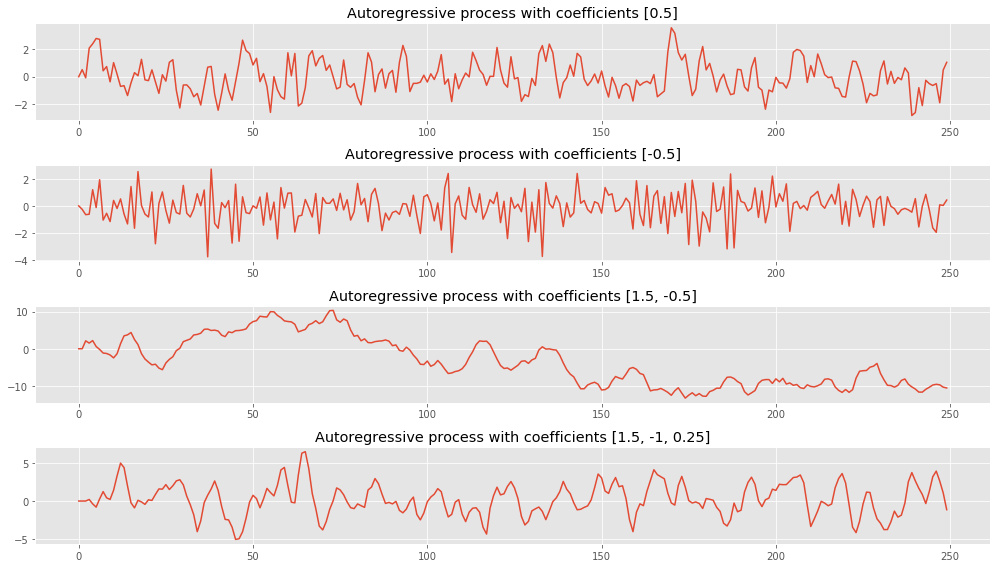

In [42]:
def autoregressive_process(size, coefs, init=None):
    '''
    Generate an autoregressive process with Gaussian white noise
    Implementation from http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
    How exactly lfilter works here takes some pen and paper effort
    '''

    coefs = np.asarray(coefs)
    if init == None:
        init = np.array([0]*len(coefs))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))

def plot_autoregressive_process(size, coefs, ax, init=None):
    ar = autoregressive_process(size, coefs, init)
    ax.plot(ar.index, ar)

ar_coefs = [[0.5], [-0.5], [1.5, -0.5], [1.5, -1, 0.25]]

_, axs = plt.subplots(4, figsize=(14, 8))

for ax, coefs in zip(axs, ar_coefs):
    plot_autoregressive_process(250, coefs, ax=ax)
    ax.set_title('Autoregressive process with coefficients {}'.format(str(list(coefs))))

plt.tight_layout()

**Discussion:** What will the autocorrelation of an AR time series look like?

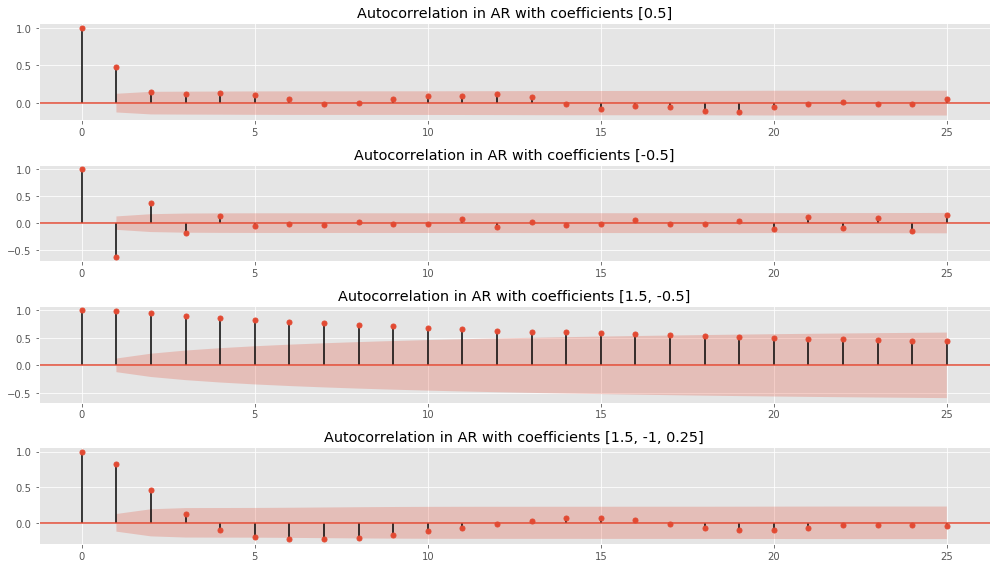

In [43]:
_, axs = plt.subplots(4, figsize=(14, 8))

for ax, coefs in zip(axs, ar_coefs):
    time_series = autoregressive_process(250, coefs)
    sm.graphics.tsa.plot_acf(time_series, lags=25, ax=ax)
    ax.set_title('Autocorrelation in AR with coefficients {}'.format(str(list(coefs))))

plt.tight_layout()

In an AR process, even thought subsequent data points are only *directly* influenced by a few previous data points, the influence tends to linger for a long time.

We can see this lingering influence in:
- The gradual decrease in autocorrelation when the initial coefficient is positive
- The sinusoidal behavior when there is negative coefficients

For AR processes, controlling for this lingering influence with a *partial* autocorrelation plot is important.

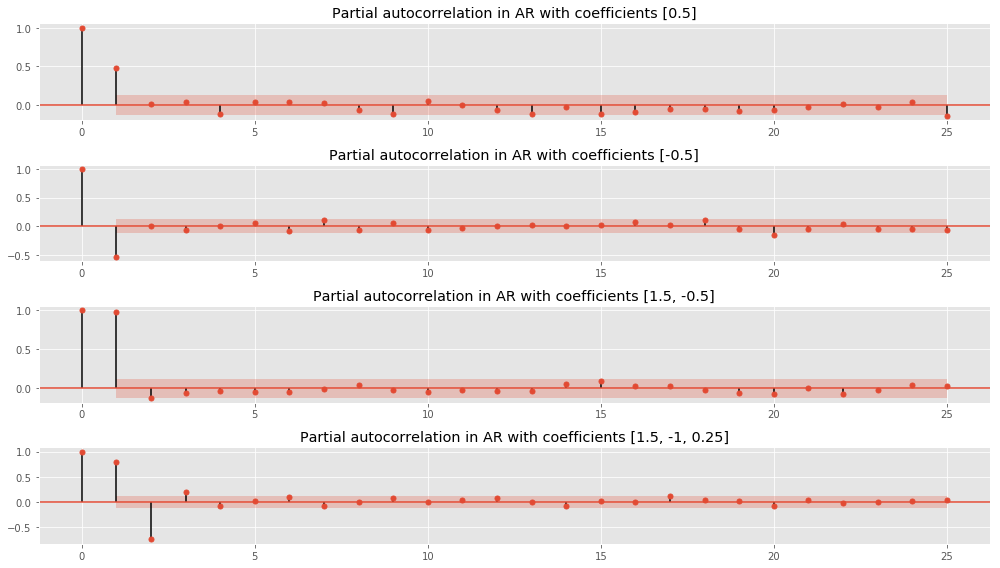

In [44]:
_, axs = plt.subplots(4, figsize=(14, 8))

for ax, coefs in zip(axs, ar_coefs):
    time_series = autoregressive_process(250, coefs)
    sm.graphics.tsa.plot_pacf(time_series, lags=25, ax=ax)
    ax.set_title('Partial autocorrelation in AR with coefficients {}'.format(str(list(coefs))))

plt.tight_layout()

In the partial autocorrelation plot, we see very distinctly that the number of significant spikes is directly influenced by the number of non-zero coefficients.

### AR Models

Given stationary time series data, a reasonable question to ask is the following:

> Which AR time series would be most likely to generate this data?

This is the concept behind AR models.

Let's generate some AR data, fit some AR models, then compare the coefficients.

In [45]:
def AR(time_series, order):
    # ARIMA is a more general model, which we are going to build up in pieces.
    return ARIMA(time_series, order=(order, 0, 0)).fit()

for coefs in ar_coefs:
    order = len(coefs)
    time_series = autoregressive_process(250, coefs)
    model = AR(time_series.values, order)
    print "True      Coefficients: {: <26}\nEstimated Coefficients: {: <26}\n".format(
            str(format_floats(coefs)),
            str(format_floats(model.params[1:])))

True      Coefficients: ['0.50']                  
Estimated Coefficients: ['0.58']                  

True      Coefficients: ['-0.50']                 
Estimated Coefficients: ['-0.51']                 

True      Coefficients: ['1.50', '-0.50']         
Estimated Coefficients: ['1.55', '-0.55']         

True      Coefficients: ['1.50', '-1.00', '0.25'] 
Estimated Coefficients: ['1.39', '-0.91', '0.24'] 



Just like for MA models, it looks like out AR models recover the true coefficients from an AR process.

### ARMA Models

Now that we have discussed AR and MA models, we can *combine* them into ARMA models, which have both AR and MA components.

ARMA models have both:
- A **linear combination of white noise** component (the MA), where subsequent values of the time series are (partially) a linear combination of white noise
- An **autoregressive component** the (AR), where subsequent values of the time series are (partially) a linear combination of previous terms, plus noise

$$s_i = \mu + \overbrace{e_i + a_1 e_{i-1} + \cdots + a_k e_{i-k}}^{\text{MA component}} + \overbrace{b_1 y_{i-1} + b_2 y_{i-2} + \cdots + b_k y_{i-k} + \epsilon_i}^{\text{AR component}}$$

### ARIMA Models

The **I** in ARIMA stands for **integrated**.

The word *integration* is used here as the opposite of *difference*.

**Recall:** We often have to take the *first differences* of time series we find in nature to make then *stationary*.

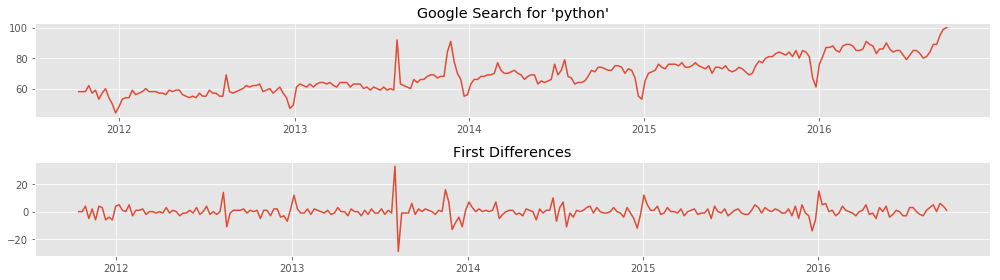

In [46]:
_, axs = plt.subplots(2, figsize=(14, 4))

plot_time_series_and_first_difference(axs, 'python')

plt.tight_layout()

MA and AR (and, consequently ARMA) models *only apply to* stationary time series.

So to model time series in nature, we often have to model the *differenced* time series as an ARMA process.

This leads us, finally, to **ARIMA**.

An **ARIMA(p, d, q)** model:
- Applies an ARMA model to time series that has been differenced $d$ times
- The AR part of the ARMA model has order $p$
- The MA part of the ARMA model has order $q$

Let's explore generating some data as an ARIMA process.

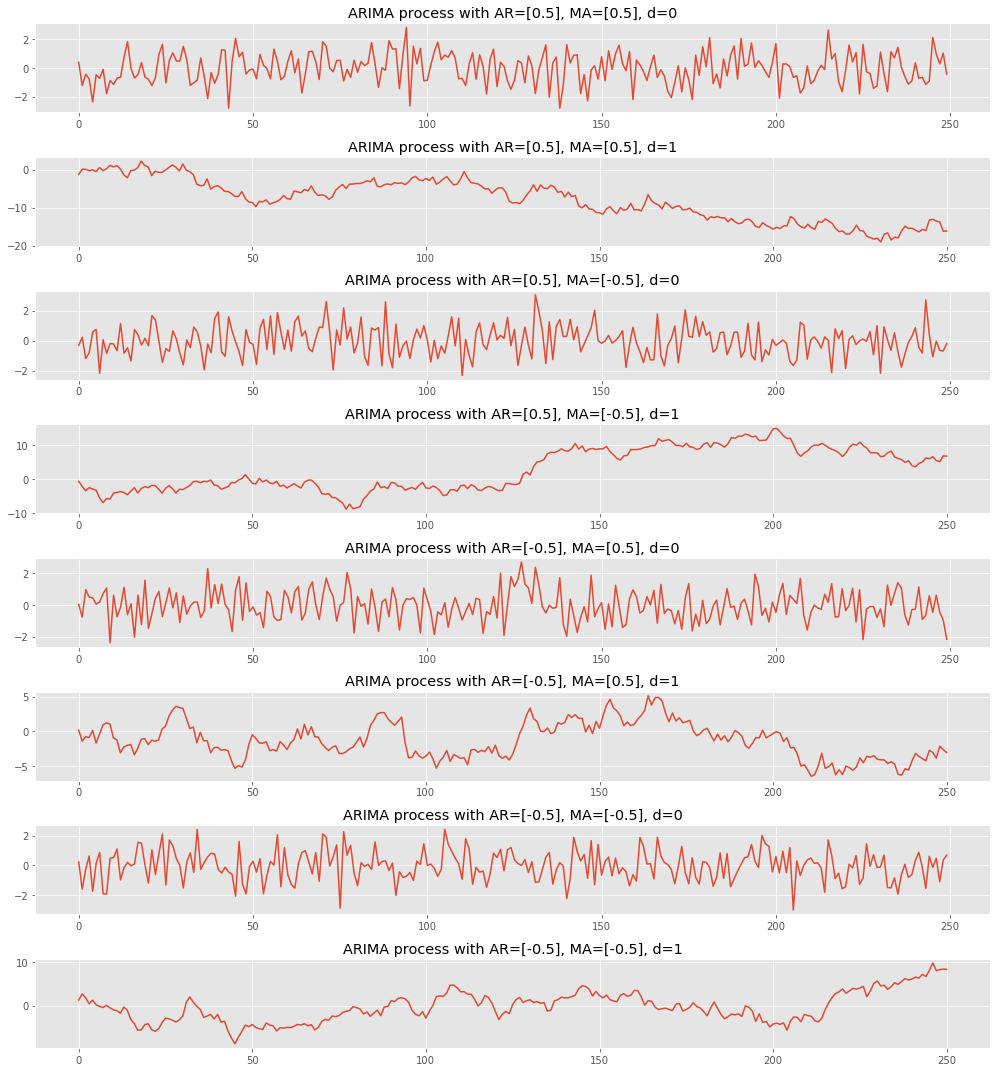

In [47]:
def arima_process(size, ar_coefs, ma_coefs, d=0):
    '''Simulate a time series from an ARIMA model'''

    time_series = ArmaProcess(ar_coefs, ma_coefs).generate_sample(size + d)

    # Integrate d times
    for _ in xrange(d):
        time_series = np.cumsum(time_series)

    return pd.Series(time_series)

def plot_arima_process(size, ar_coefs, ma_coefs, ax, d=0):
    time_series = arima_process(size, ar_coefs, ma_coefs, d)
    ax.plot(time_series.index, time_series)

ar_coefs = [[0.5], [-0.5]]
ma_coefs = [[0.5], [-0.5]]
ds = [0, 1]

_, axs = plt.subplots(8, figsize=(14, 15))

for ax, (ar, ma, d) in zip(axs, itertools.product(ar_coefs, ma_coefs, ds)):
    plot_arima_process(250, ar, ma, d=d, ax=ax)
    ax.set_title('ARIMA process with AR={}, MA={}, d={}'.format(ar, ma, d))

plt.tight_layout()

And, one final time, fitting an ARIMA model recovers the coefficients of a simulated ARIMA process.

### Case Study:  Electrical Equipment Orders Data

Let's attempt to fit an ARIMA model to a time series of electrical orders, and use it to forecast future values.

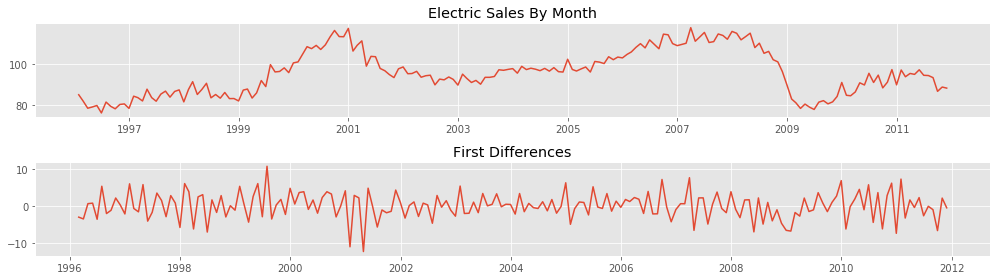

In [48]:
filename = os.path.join('.', 'data', 'electrical-sales.csv')
df = pd.read_csv(filename, parse_dates=['month'], index_col='month')
time_series = df.sales

_, axs = plt.subplots(2, figsize=(14, 4))

plot_time_series_and_first_difference(axs, 'Electric Sales By Month', time_series)

plt.tight_layout()

The original time series is clearly **not** stationary, so we differenced it.  The resulting time series looks stationary, but let's use a test to check.

In [49]:
differenced_time_series = time_series.diff()[1:]
test = sm.tsa.stattools.adfuller(differenced_time_series)
print 'ADF p-value for differenced time series: {:2.2f}'.format(test[1])

ADF p-value for differenced time series: 0.00


So the differenced time series is stationary, and we can attempt to model it as an ARMA process.

We need to determine the correct order for the AR and MA models, so let's look at the auto and partial auto correlation plots.

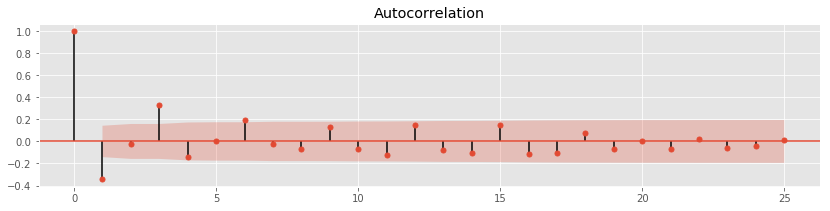

In [50]:
_, ax = plt.subplots(1, figsize=(14, 3))
sm.graphics.tsa.plot_acf(differenced_time_series, lags=25, ax=ax);

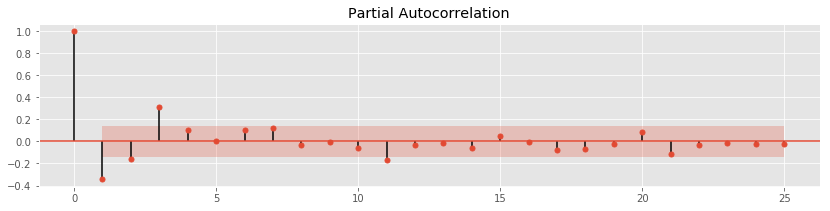

In [51]:
_, ax = plt.subplots(1, figsize=(14, 3))
sm.graphics.tsa.plot_pacf(differenced_time_series, lags=25, ax=ax);

We see the following evidence:
- Oscillatory behavior in the autocorrelation plot
- Three significant partial autocorrelations at the beginning of the plot

This suggests that the differenced time series may be well modeled as an AR(3) time series.

Since we applied *one* difference to achieve seasonality, this suggests that we should model the *original* time series as an ARIMA(3, 1, 0).

In [52]:
model = ARIMA(time_series, order=(3, 1, 0)).fit()

In [53]:
print 'ARIMA(3, 1, 0) coefficients from Electric model:\n- Intercept {:2.2f}\n- AR {}'.format(
    model.params[0], format_floats(list(model.params[1:])))

ARIMA(3, 1, 0) coefficients from Electric model:
- Intercept 0.01
- AR ['-0.35', '-0.04', '0.31']


Let's use this model to project electric sales into the future:

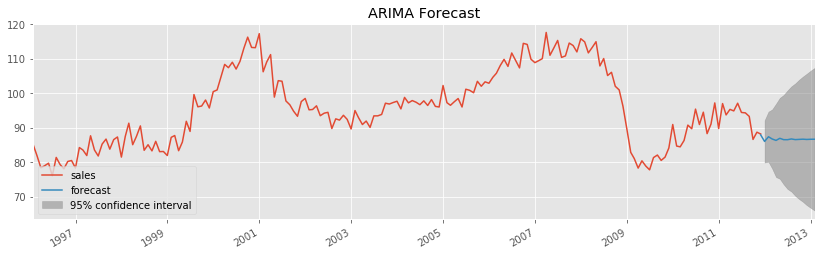

In [54]:
time_series.reindex(pd.DatetimeIndex(start='01-1996', end='12-2012', freq='M'))

_, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(time_series.index, time_series)

model.plot_predict('2011-11-30', '2013', dynamic=True, ax=ax, plot_insample=False)

ax.legend().get_texts()[1].set_text('95% Prediction Interval')
ax.legend(loc='lower left')

ax.set_title('ARIMA Forecast')

Zooming in, we can see that we **have** done a bit better than the naive forecast of predicting the last observed value:

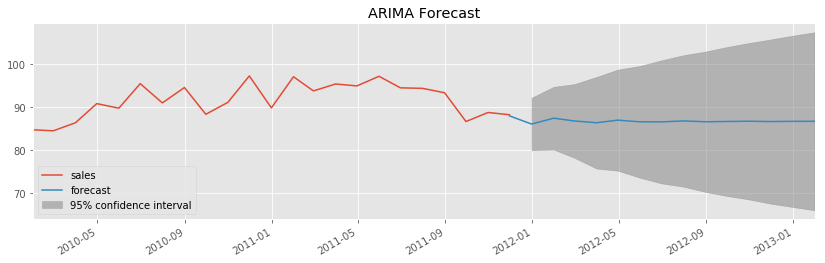

In [55]:
time_series.reindex(pd.DatetimeIndex(start='01-1996', end='12-2012', freq='M'))

_, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(time_series['2010':].index, time_series['2010':])

model.plot_predict('2011-11-30', '2013', dynamic=True, ax=ax, plot_insample=False)

ax.legend().get_texts()[1].set_text('95% Prediction Interval')
ax.legend(loc='lower left')
ax.set_title('ARIMA Forecast')

If our model is good, the residuals should have no patterns whatsoever, i.e., be *white noise*.

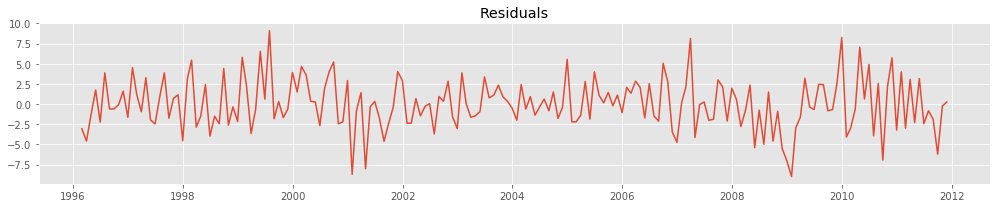

In [56]:
_, ax = plt.subplots(1, figsize=(14, 3))

ax.plot(model.resid.index, model.resid)
ax.set_title('Residuals')

plt.tight_layout()

One way to diagnose this is to check if any autocorrelation remains in the residuals.

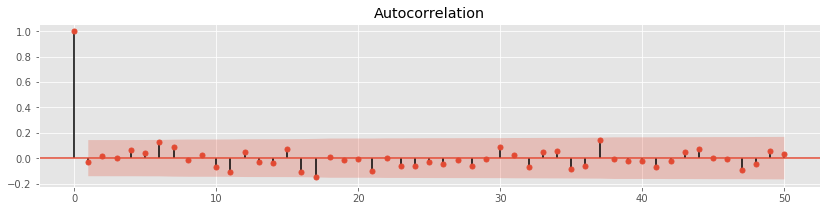

In [57]:
_, ax = plt.subplots(1, figsize=(14, 3))
sm.graphics.tsa.plot_acf(model.resid, lags=50, ax=ax);

All the autocorrelations are within the confidence bands, so it looks like our model fits the data well.

### Model Selection: AIC

We made our selection of model based on the autocorrelation and partial autocorrelation plot, which is a good first step.

The overall procedure we followed is called the **Box-Jenkins Method**.

Hyndmann recommends also trying a few models that are "close by", varying the ARMA parameters slightly, and then selecting the best model from the results using an information criteria.

In [58]:
parameters = [
    {'AR': 3, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 4, 'MA': 0},
    {'AR': 3, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(time_series, order=(params['AR'], 1, params['MA'])).fit()

for model_params in models:
    print 'ARIMA({}, 1, {}) AIC: {}'.format(model_params[0], model_params[1], models[model_params].aic)

ARIMA(3, 1, 0) AIC: 981.330385414
ARIMA(2, 1, 0) AIC: 998.653170318
ARIMA(3, 1, 1) AIC: 980.161716283
ARIMA(4, 1, 0) AIC: 980.904639589


The ARIMA(3, 1, 1) model has a *slightly* better AIC, so following Hyndmann, we would select this as our final model.

The overall methodology for producing an ARIMA model is summarized in the following flowchart, taken from Hyndmann.

![Hyndmann Modeling Process](./images/hyndman-modeling-process.png)